<a href="https://colab.research.google.com/github/datawilly/aprendizaje-por-refuerzo/blob/main/Rosales_William_PEC1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ejercicio de Iteración de Valor

## Instalar los requerimientos

In [ ]:
!pip install -r requirements.txt

  Using cached torch-2.3.0-cp39-cp39-win_amd64.whl (159.7 MB)
  Using cached torchvision-0.18.0-cp39-cp39-win_amd64.whl (1.2 MB)
  Using cached torchaudio-2.3.0-cp39-cp39-win_amd64.whl (2.4 MB)
  Using cached mkl-2021.4.0-py2.py3-none-win_amd64.whl (228.5 MB)
  Using cached intel_openmp-2021.4.0-py2.py3-none-win_amd64.whl (3.5 MB)
  Using cached tbb-2021.12.0-py3-none-win_amd64.whl (286 kB)


ERROR: Cannot uninstall 'TBB'. It is a distutils installed project and thus we cannot accurately determine which files belong to it which would lead to only a partial uninstall.


  Attempting uninstall: tbb
    Found existing installation: TBB 0.2


## Importar dependencias

In [ ]:
import gymnasium as gym
import numpy as np
from plot_utils import plot_values

## Para hacer: Arregla el código para desarrollar tu algoritmo de Iteración de Valor

In [ ]:
class ValueIteration:
    #En el constructor vamos a referenciar el entorno de Gym, el valor de descuento Gamma, tambien el umbral
    #de convergencia, es importante establecer explicitamente las recompensas del juego para los estados
    #esto sirve para que nuestro agente pueda hacer los cálculos y por último la funcion de valor inicializada en cero
    #y que se actualizará conforme nuestro agente juegue
    def __init__(self, env: gym.Env, gamma: float, epsilon: float):
        self.env = env
        self.gamma = gamma
        self.epsilon = epsilon
        self.reward = {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.0, 13: 0.0, 14: 0.0, 15: 1.0}
        self.V = np.zeros(env.observation_space.n)

    #Iniciamos con el método train, donde vamos a entrenar al agente mediante la iteracion de valor y su funcion es
    #correr el bucle while hasta que el valor de delta, que corresponde a los cambios en la funcion de valor,
    #sea mas pequeño que epsilon, valor que nosotros establecemos y cuando esta condicion se de, se entenderá como
    #alcanzada la convergencia
    def train(self) -> tuple[np.ndarray, np.ndarray]:
        while True:
            #Inicializamos la variable delta que va a guardar los valores del cambio de la funcion de valor
            delta = 0
            #Vamos a recorrer todos los estados en el entorno
            for state in range(self.env.observation_space.n):
                #Guardamos el estado en el que nos encontramos
                v = self.V[state]
                #Llamamos al método get_q_from_v que se encuentra declarado mas abajo el cual nos va a dar los valores Q
                #para el estado actual que está recorriendo el bucle
                action_values = self.get_q_from_v(state)
                #Actualizamos la función de valor v para el estado actual con el valor Q máximo
                self.V[state] = max(action_values)
                #Reasignamos a nuestra variable delta el cambio máximo del valor para cualquier estado del juego
                delta = max(delta, abs(v - self.V[state]))

            #Establecemos una nueva condicion, la cual verifica que nuestro delta es menor que el epsilon declarado
            #mas abajo, de ser así rompe el bucle while ya que alcanzaríamos la convergencia,
            #si esta condicion no se cumple volvemos a iniciar otra iteracion
            if delta < self.epsilon:
                break


        #Aquí vamos a guardar la política que hemos encontrado a través del bucle en base a la funcion de valor llamando
        #a la funcion policy_improvement y pasandole el resultado de la funcion de valor obtenida
        policy = self.policy_improvement(self.V)
        #Devolvemos la política y la funcion de valor
        return policy, self.V

    #Seguimos con el método de mejora de la política, aquí vamos a mejorar la política en funcion de las Q
    #obtenidas a travpes del método get_q_from_v para cada estado y acción, de los cuales nos quedamos con el
    #valor mas alto para establecer la nueva política mejorada
    def policy_improvement(self, V: np.ndarray) -> np.ndarray:
        #Inicializamos la política en ceros
        policy = np.zeros(self.env.observation_space.n, dtype=int)
        #Iniciamos un bucle for que va a iterar en cada estado del entorno
        for state in range(self.env.observation_space.n):
            #Vamos a obtener la Q para cada estado y la guardamos en una nueva variable
            action_values = self.get_q_from_v(state)
            #Obtenemos el mayor valor para cada estado de acuerdo a las acciones las cuales guardamos en la linea anterior
            #y la guardamos en la política mejorada
            policy[state] = np.argmax(action_values)
        #Devolvemos la política
        return policy

    #Inicializamos la funcion get_q_from_v la cual obtiene los valores iterando en cada acción posible
    def get_q_from_v(self, state: int) -> np.ndarray:
        #Inicializamos los valores de Q en cero
        Q = np.zeros(self.env.action_space.n)
        #Creamos un bucle for el cual va a recorrer las acciones para obtener Q
        for action in range(self.env.action_space.n):
            #Vamos a obtener para cada acción la probabilidad de cada una, el estado siguiente al que llegaríamos
            #la recompensa y un valor adicional el cual vamos a omitir, y este nuevo bucle for va a iterar a lo
            #largo de cada pareja de estado y acción
            for prob, next_state, reward, _ in self.env.P[state][action]:
                #Para cada una de las acciones vamos a calcular la Q mediante la fórmula que multiplica la probabilidad
                #por la suma de la recompensa mas el producto del valor de descuento y la funcion de valor en el siguiente
                #estado
                Q[action] += prob * (self.reward[state] + self.gamma * self.V[next_state])
        #Devolvemos el valor de Q
        return Q

    def play(self, policy: np.ndarray, episodes=1) -> list[float]:
        total_rewards = []
        for _ in range(episodes):
            total_reward = 0.0
            state, _ = self.env.reset()
            while True:
                action = policy[state]
                state, reward, done, _, _ = self.env.step(action)
                total_reward += reward
                if done:
                    break
            total_rewards.append(total_reward)
        return total_rewards


## Observa a tu agente jugar

C:\Users\William\anaconda3\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.P to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.P` for environment variables or `env.get_wrapper_attr('P')` that will search the reminding wrappers.
  logger.warn(


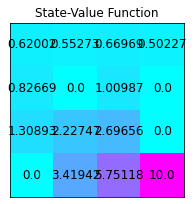

Política óptima:
[0 3 0 3 0 0 0 0 3 1 0 0 0 2 1 0]
Recompensa final: 9.999999999142268


In [ ]:
#Se establece el tamaño del entorno del juego, en este caso 4
size = 4
#Declaramos el entorno de juego
env = gym.make(
    "FrozenLake-v1",
    desc=None,
    map_name=f"{size}x{size}",
    is_slippery=True,
    render_mode="human",
)
#Asignamos el valor de descuento
gamma = 0.9
pi_error = 1e-10
#Asignamos el valor que nos va a ayudar para establecer la convergencia
epsilon = 1e-10
#Iniciamos la iteracion de valor
value_iteration = ValueIteration(env, gamma, pi_error)
policy, V = value_iteration.train()
value_iteration.play(policy)
env.close()
#Mostramos cada uno de los resultados de la funcion de valor
plot_values(V, size)
#Veamos la política óptima
print("Política óptima:")
print(policy)

#Calculamos la recompensa esperada para el juego
expected_reward = V[15]
print("Recompensa final:", expected_reward)

## Verifica que tu solución sea correcta


In [ ]:
#Vamos a declarar la politica optima encontrada
optimal_policy = [0, 3, 0, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1, 0]

#nuevamente declaramos el entorno
size = 4
env = gym.make(
    "FrozenLake-v1",
    desc=None,
    map_name=f"{size}x{size}",
    is_slippery=True,
    render_mode="human",
)

#Le pasamos la política al entorno
env.env.P = np.array(optimal_policy)

#Ejecutamos para ver la política en accíon
state = env.reset()[0]
done = False
while not done:
    env.render()
    action = optimal_policy[state]
    state, _, done, _ = env.step(action)[:4]

# Cierra la ventana de renderizado al finalizar
env.close()